In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from s_dbw import S_Dbw

In [2]:
# resets index after selections have been made
def resetindex(data):
    data=data.reset_index()
    data=data.drop('index', axis=1)
    return data

In [3]:
#reduces the data set to the first m iterations
def firstiterations(m,data):
    i=0
    j=0
    n=len(data.index)    
    while i<n:
        if  (data.iat[j,10]>m):
            data=data.drop(i, axis=0)
            i=i+1
        else:
            i=i+1
            j=j+1
    data=resetindex(data)
    return data

In [4]:
# Generate a Series with a specific length, so that all residuals of one parameter combination are in one line
def GenerateSeries(source, Length):
    output=source.iloc[:,[4,5]]
    output=output.drop_duplicates()
    output=resetindex(output)
    for j in range(1, Length+1):
        output[f'ResidualNorm{j}']=0.0
        for i in range(len(output.index)):
            Abfrage=source.query( f"`Droptol`=={output.iat[i,0]} and `Fillfactor`=={output.iat[i,1]} and Iterations=={j}")
            if len(Abfrage.index)==1:
                output.iat[i,j+1]=Abfrage.iat[0,8]
            elif len(Abfrage.index)>1:
                raise Exception("Multiple instances with same Droptol, Fillfactor and Iteration within one Beta")
    return output

In [5]:
df=pd.read_csv('PCGDim16129.txt', sep='\t')
df=df.drop('Convergence Mode', axis=1)

In [6]:
beta=1e1
dfBeta=df.query(f"Beta=={beta}")
dfBeta=resetindex(dfBeta)
# number of points based on the needed amount in the exploration algorithm 
usedpoints=52

In [7]:
possiblepoints=dfBeta[['Droptol','Fillfactor']]
possiblepoints=possiblepoints.drop_duplicates()
possiblepoints=resetindex(possiblepoints)
indexNames = possiblepoints[ (possiblepoints['Fillfactor'] == 0)
                & (possiblepoints['Droptol'] == 1e-12) ].index
possiblepoints.drop(indexNames , inplace=True)

indexNames = possiblepoints[ (possiblepoints['Fillfactor'] == 9)
                & (possiblepoints['Droptol'] == 1e-12) ].index
possiblepoints.drop(indexNames , inplace=True)

indexNames = possiblepoints[ (possiblepoints['Fillfactor'] == 0)
                & (possiblepoints['Droptol'] == 1e+4) ].index
possiblepoints.drop(indexNames , inplace=True)

indexNames = possiblepoints[ (possiblepoints['Fillfactor'] == 9)
                & (possiblepoints['Droptol'] == 1e+4) ].index
possiblepoints.drop(indexNames , inplace=True)
possiblepoints=resetindex(possiblepoints)

In [8]:
fullycolored=0
for rounds in range(0,1):    
    print(rounds)
    basis=dfBeta.query("(Fillfactor==0 or Fillfactor==9) and (Droptol==1e-12 or Droptol==1e+4)")
    basis=resetindex(basis)
    pointssample=possiblepoints.sample(n = (usedpoints-4)) 

    points=basis[["Droptol","Fillfactor"]]
    points = points.drop_duplicates()
    points = resetindex(points)


    points=[points,pointssample]
    points = pd.concat(points)
    points = points.drop_duplicates()
    points = resetindex(points)
    

    basis=dfBeta.query(f"Droptol=={points.iat[0,0]} and Fillfactor=={points.iat[0,1]}")

    j=1
    while j<len(points.index):
        basisadd=dfBeta.query(f"Droptol=={points.iat[j,0]} and Fillfactor=={points.iat[j,1]}")
        basis=[basis,basisadd]
        basis=pd.concat(basis)
        j=j+1
    
    basis=resetindex(basis)

    #test different combinations and compute S_Dbw score
    clustermax=12
    optimizationgrid=np.zeros([7,clustermax-2])
    for SeriesLength in range(3,10):
        for clustercount in range(2,clustermax):
            series=GenerateSeries(basis,SeriesLength)
            scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
            scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
            kmeans=KMeans(n_clusters=clustercount)
            y=kmeans.fit_predict(scaled_clusterdata)
            UnsortedClusters=y
            labels=kmeans.labels_
            score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')
            optimizationgrid[SeriesLength-3,clustercount-2]= score
        
    # take best option based on the score      
    minima=np.argwhere((optimizationgrid == np.min(optimizationgrid)))
    minima=minima[0]
    SeriesLength=minima[0]+3
    clustercount=minima[1]+2
    

    series=GenerateSeries(basis,SeriesLength)
    scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
    scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
    kmeans=KMeans(n_clusters=clustercount)
    y=kmeans.fit_predict(scaled_clusterdata)
    UnsortedClusters=y
    labels=kmeans.labels_
    score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind',\
                  centr='mean', nearest_centr=True, metric='euclidean')



    #Take best combination and sort clusters
    SortingValues=np.zeros(clustercount)
    SortData=pd.DataFrame(series[f'ResidualNorm{SeriesLength}'])
    SortData['UnsortedClusters']=y
    for i in range(0,clustercount):
        ResOfCluster=SortData.query(f'UnsortedClusters=={i}')
        sums=ResOfCluster[f"ResidualNorm{SeriesLength}"].sum()
        SortingValues[i]=sums/len(ResOfCluster.index)
    
    Sorting=np.argsort(np.argsort(SortingValues))
    Clusters=np.zeros(shape=len(UnsortedClusters))
    for i in range(0,len(Clusters)):
        Clusters[i]=Sorting[UnsortedClusters[i]]
    Clusters=np.int_(Clusters)

    series['Cluster']=Clusters


    Droptols=basis["Droptol"].unique()
    Droptols=np.sort(Droptols)
    minDroptol=Droptols[0]
    maxDroptol=Droptols[len(Droptols)-1]

    Fillfactors=basis["Fillfactor"].unique()
    Fillfactors=np.sort(Fillfactors)
    minFillfactor=Fillfactors[0]
    maxFillfactor=Fillfactors[len(Fillfactors)-1]
    
    
    tobedetermined=pd.DataFrame(columns=["Droptol","Fillfactor"])
    tobedetermined["Droptol"]=tobedetermined["Droptol"].astype(float)
    tobedetermined["Fillfactor"]=tobedetermined["Fillfactor"].astype(int)
    
    
    #vertical axis
    for i in range(0,len(Droptols)):
    
        #left and right boundary
        if (Droptols[i]==minDroptol or Droptols[i]==maxDroptol):
            
            #which points exist for a certain Droptol, sorted ascending by Fillfactor
            temp=(series.query(f"Droptol=={Droptols[i]}")).sort_values(by=["Fillfactor"])
            temp=resetindex(temp)
            for j in range(0,len(temp.index)-1):
                #comparison of pairs of direct point
                if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)}, ignore_index=True)
                
        else:
            temp=(series.query(f"Droptol=={Droptols[i]}")).sort_values(by="Fillfactor")
            temp=resetindex(temp)
            curDroptol=Droptols[i]

        
            #look at points "above"
            for j in range(0,len(temp.index)):
            
                curFillfactor=temp.iat[j,1]
            
                if curFillfactor==maxFillfactor:
                    break
                
                optFillfactors=Fillfactors
                mask=(optFillfactors)>curFillfactor
                optFillfactors=optFillfactors[mask]
                optFillfactors=sorted(optFillfactors)
                
                for k in range(0,len(optFillfactors)):
                
                    if (series.query(f"Droptol=={curDroptol} and Fillfactor=={optFillfactors[k]}")).empty:
                        above=(series.query(f"Droptol>{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"])                    
                        under=(series.query(f"Droptol<{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"], ascending=False)
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curFillfactor+optFillfactors[k])/2)!=minFillfactor):
                                        tobedetermined=tobedetermined.append({'Droptol':curDroptol,'Fillfactor':math.floor((curFillfactor+optFillfactors[k])/2)}, ignore_index=True)
                                break
                            
                    else:
                        if k<len(optFillfactors):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)!=minFillfactor):
                                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j+1,SeriesLength+2]:
                                break
        
            #look at points "under"
            for j in range(0,len(temp.index)):
                
                curFillfactor=temp.iat[j,1]

                if curFillfactor==minFillfactor:
                    break
                
                optFillfactors=Fillfactors
                mask=(optFillfactors)<curFillfactor
                optFillfactors=optFillfactors[mask]
                optFillfactors=sorted(optFillfactors, reverse=True)

                for k in range(0,len(optFillfactors)):
                    
                    if (series.query(f"Droptol=={curDroptol} and Fillfactor=={optFillfactors[k]}")).empty:
                        above=(series.query(f"Droptol>{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"])                    
                        under=(series.query(f"Droptol<{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"], ascending=False)
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curFillfactor+optFillfactors[k])/2)!=minFillfactor):
                                        tobedetermined=tobedetermined.append({'Droptol':curDroptol,'Fillfactor':math.floor((curFillfactor+optFillfactors[k])/2)}, ignore_index=True)
                                break
                    else:
                        if k<len(optFillfactors):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j-1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,1]+temp.iat[j-1,1])/2)!=minFillfactor):
                                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j-1,1])/2)}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j-1,SeriesLength+2]:
                                break
                        
    
    
    
    
    
    
    #horizontal axis
    for i in range(0,len(Fillfactors)):
    
        #upper and lower boundary
        if (Fillfactors[i]==minFillfactor or Fillfactors[i]==maxFillfactor):
            #which points exist for a certain Fillfactor, sorted ascending by Droptol
            temp=(series.query(f"Fillfactor=={Fillfactors[i]}")).sort_values(by=["Droptol"])
            temp=resetindex(temp)
            for j in range(0,len(temp.index)-1):
                #comparison of pairs of direct point
                if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                    tobedetermined=tobedetermined.append({'Droptol':10**(math.floor((math.log10(temp.iat[j,0])+math.log10(temp.iat[j+1,0]))/4)*2),'Fillfactor':temp.iat[j,1]}, ignore_index=True)
            
        else:
            temp=(series.query(f"Fillfactor=={Fillfactors[i]}")).sort_values(by="Droptol")
            temp=resetindex(temp)
            curFillfactor=Fillfactors[i]
        
            #look at points "to the right"
            for j in range(0,len(temp.index)):
            
                curDroptol=temp.iat[j,0]

                if curDroptol==maxDroptol:
                    break
                
                optDroptols=Droptols
                mask=(optDroptols)>curDroptol
                optDroptols=optDroptols[mask]
                optDroptols=sorted(optDroptols)
            
                for k in range(0,len(optDroptols)):

                    if (series.query(f"Droptol=={optDroptols[k]} and Fillfactor=={curFillfactor}")).empty:
                        above=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor>{curFillfactor}")).sort_values(by=["Fillfactor"])                    
                        under=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor<{curFillfactor}")).sort_values(by=["Fillfactor"], ascending=False)

                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (10**(math.floor((math.log10(curDroptol)+math.log10(optDroptols[k]))/4)*2)!=minDroptol):
                                        tobedetermined=tobedetermined.append({'Droptol':10**(math.floor((math.log10(curDroptol)+math.log10(optDroptols[k]))/4)*2),'Fillfactor':curFillfactor}, ignore_index=True)
                                break
                    else:
                        if k<len(optDroptols):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                                if (10**(math.floor((math.log10(temp.iat[j,0])+math.log10(temp.iat[j+1,0]))/4)*2)!=minDroptol):
                                    tobedetermined=tobedetermined.append({'Droptol':10**(math.floor((math.log10(temp.iat[j,0])+math.log10(temp.iat[j+1,0]))/4)*2),'Fillfactor':temp.iat[j,1]}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j+1,SeriesLength+2]:
                                break
        
        
            #look at points "to the left"
            for j in range(0,len(temp.index)):
                
                curDroptol=temp.iat[j,0]

                if curDroptol==minDroptol:
                    break
                
                optDroptols=Droptols
                mask=(optDroptols)<curDroptol
                optDroptols=optDroptols[mask]
                optDroptols=sorted(optDroptols, reverse=True)
            
                for k in range(0,len(optDroptols)):

                    if (series.query(f"Droptol=={optDroptols[k]} and Fillfactor=={curFillfactor}")).empty:
                        above=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor>{curFillfactor}")).sort_values(by=["Fillfactor"])                    
                        under=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor<{curFillfactor}")).sort_values(by=["Fillfactor"], ascending=False)
                    
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (10**(math.floor((math.log10(curDroptol) + math.log10(optDroptols[k]))/4)*2)!=minDroptol):
                                        tobedetermined=tobedetermined.append({'Droptol':10**(math.floor((math.log10(curDroptol) + math.log10(optDroptols[k]))/4)*2) ,'Fillfactor': curFillfactor}, ignore_index=True)
                                break
                    else:
                        if k<len(optDroptols):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j-1,SeriesLength+2]:
                                if (10**(math.floor((math.log10(temp.iat[j,0])+math.log10(temp.iat[j-1,0]))/4)*2)!=minDroptol):
                                    tobedetermined=tobedetermined.append({'Droptol':10**(math.floor((math.log10(temp.iat[j,0])+math.log10(temp.iat[j-1,0]))/4)*2) ,'Fillfactor':temp.iat[j,1]}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j-1,SeriesLength+2]:
                                break
                                
                                
    tobedetermined=tobedetermined.drop_duplicates()
    tobedetermined=resetindex(tobedetermined)                            
                                
    points=basis[["Droptol","Fillfactor"]]
    points = points.drop_duplicates()
    points = resetindex(points)

    NumberOldPoints=len(points.index)

    points=[points,tobedetermined]
    points = pd.concat(points)
    points = points.drop_duplicates()
    points = resetindex(points)
    NumberNewPoints=len(points.index)

    if NumberOldPoints==NumberNewPoints:
        fullycolored=fullycolored+1
                     
    
    

0


In [9]:
print('fullycolored= ', fullycolored)

fullycolored=  0


<br>
<br>
<br>
<strong> Visualizing parameter space

In [10]:
list=['0','1','2','3','4','5','6','7','8','9','10']
for cl in range(0,clustercount):
    vars()["PredictionGroup"+list[cl]]=series.query(f"`Cluster`=={cl}")

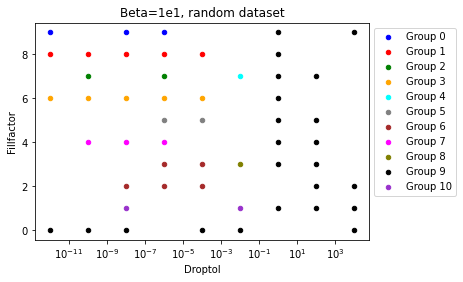

In [11]:
ax = PredictionGroup0.plot(kind='scatter', x='Droptol', y='Fillfactor',color='blue', label='Group 0');
PredictionGroup1.plot(kind='scatter', x='Droptol', y='Fillfactor',color='red', label='Group 1', ax=ax);
if clustercount>2:
    PredictionGroup2.plot(kind='scatter', x='Droptol', y='Fillfactor',color='green', label='Group 2', ax=ax);
    if clustercount>3:
        PredictionGroup3.plot(kind='scatter', x='Droptol', y='Fillfactor',color='orange', label='Group 3', ax=ax);
        if clustercount>4:
            PredictionGroup4.plot(kind='scatter', x='Droptol', y='Fillfactor',color='cyan', label='Group 4', ax=ax);
            if clustercount>5:
                PredictionGroup5.plot(kind='scatter', x='Droptol', y='Fillfactor',color='gray', label='Group 5', ax=ax);
                if clustercount>6:
                    PredictionGroup6.plot(kind='scatter', x='Droptol', y='Fillfactor',color='brown', label='Group 6', ax=ax);
                    if clustercount>7:
                        PredictionGroup7.plot(kind='scatter', x='Droptol', y='Fillfactor',color='magenta', label='Group 7', ax=ax);
                        if clustercount>8:
                            PredictionGroup8.plot(kind='scatter', x='Droptol', y='Fillfactor',color='olive', label='Group 8', ax=ax);
                            if clustercount>9:
                                PredictionGroup9.plot(kind='scatter', x='Droptol', y='Fillfactor',color='black', label='Group 9', ax=ax);
                                if clustercount>10:
                                    PredictionGroup10.plot(kind='scatter', x='Droptol', y='Fillfactor',color='darkorchid', label='Group 10', ax=ax);
                                    if clustercount>11:
                                        PredictionGroup11.plot(kind='scatter', x='Droptol', y='Fillfactor',color='mistyrose', label='Group 11', ax=ax);
#tobedetermined.plot(kind='scatter', x='Droptol', y='Fillfactor',marker='o', color='none', edgecolors='black', label='tobedetermined', ax=ax);
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.title(f"Beta=1e{int(math.log10(beta))}, random dataset")
plt.show()

<br>
<br>
<br>
<strong> Visualizing trajectories

In [12]:
basis['Cluster']=0

for i in range(len(basis.index)):
    basis.iat[i,15]=(series.query(f"`Droptol`=={basis.iat[i,4]} and `Fillfactor`=={basis.iat[i,5]}")).iat[0,SeriesLength+2]
    
    
list=['0','1','2','3','4','5','6','7','8','9']
for cl in range(0,clustercount):
    vars()["Group"+list[cl]]=basis.query(f"`Cluster`=={cl}")


IndexError: list index out of range

In [ ]:
ax = Group0.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='blue', label='Group 0',s=0.5);
Group1.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='red', label='Group 1',ax=ax,s=0.5);
if clustercount>2:
    Group2.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='green', label='Group 2',ax=ax,s=0.5);
    if clustercount>3:
        Group3.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='orange', label='Group 3',ax=ax,s=0.5);
        if clustercount>4:
            Group4.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='cyan', label='Group 4',ax=ax,s=0.5);
            if clustercount>5:
                Group5.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='gray', label='Group 5', ax=ax,s=0.5);
                if clustercount>6:
                    Group6.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='brown', label='Group 6', ax=ax,s=0.5);
                    if clustercount>7:
                        Group7.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='magenta', label='Group 7', ax=ax,s=0.5);
                        if clustercount>8:
                            Group8.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='olive', label='Group 8', ax=ax,s=0.5);
                            if clustercount>9:
                                Group9.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='black', label='Group 9', ax=ax,s=0.5);
                                if clustercount>10:
                                    Group10.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='darkorchid', label='Group 10', ax=ax,s=0.5);
                                    if clustercount>11:
                                        Group11.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='mistyrose', label='Group 11', ax=ax,s=0.5);
                                
ax.set_yscale('log')
ax.set_xlim(0,200)
plt.legend(loc='lower right')
plt.title(f"Beta=1e{int(math.log10(beta))}, random dataset")
plt.show()     